# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

# Local imports
import utils
from two_body_restricted import make_traj_r2bc , make_train_r2bc
from two_body_restricted import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from two_body_restricted import make_datasets_earth, make_datasets_solar

In [2]:
# Grow GPU memory (must be first operation in TF)
utils.gpu_grow_memory()

In [3]:
# Create distribution strategy
strat = tf.distribute.MirroredStrategy()

# Plot style 
utils.plot_style()

In [4]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r=1, theta0=0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

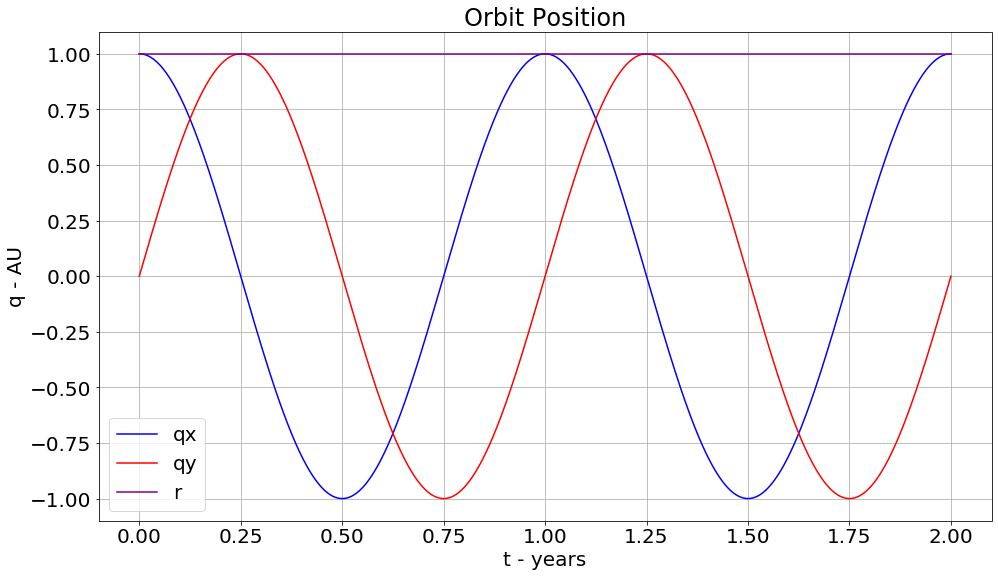

In [5]:
fig, ax = plot_orbit_q(data_earth)

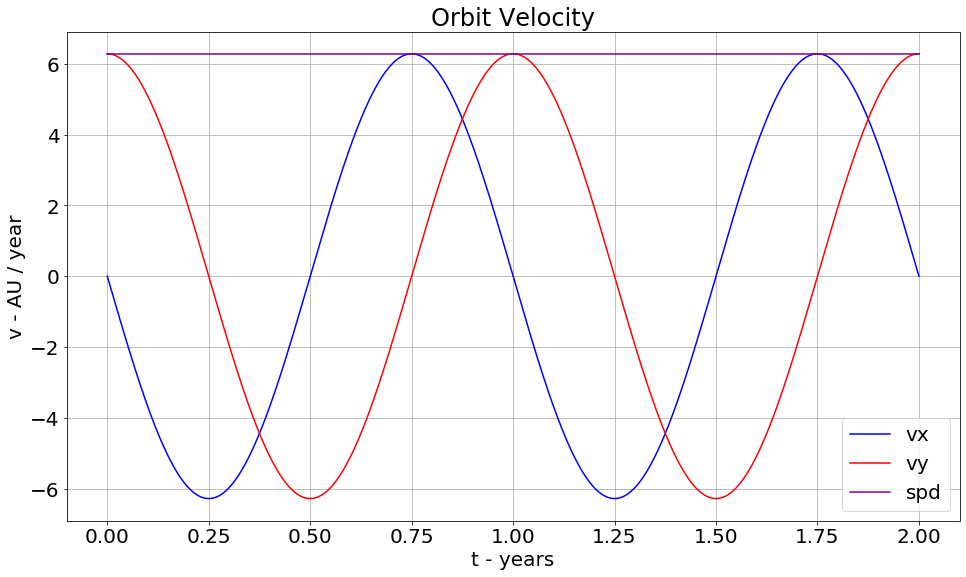

In [6]:
fig, ax = plot_orbit_v(data_earth)

In [7]:
# fig, ax = plot_orbit_a(data_earth)

In [8]:
# fig, ax = plot_orbit_energy(data_earth)

In [9]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth()

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_trn, ds_val, ds_tst = make_datasets_solar()

In [10]:
def make_model_r2bc_analytic():
    """Create an anlytical model for the restricted two body circular problem"""
    # Create input layers
    t = keras.Input(shape=(1,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    # The combined input layers
    inputs = [t, q0, v0]

    # Compute the norm of a 2D vector
    norm_func = lambda q : tf.norm(q, axis=1)

    # The radius r; this is the same at time 0 and t
    r = keras.layers.Activation(norm_func, name='r')(q0)
    
    # Cube of r    
    cube_func = lambda x : tf.pow(x, 3)
    r3 = keras.layers.Activation(cube_func, name='r3')(r)
  
    # The angular velocity omega
    mu = tf.constant((2.0*np.pi)**2, name='mu')
    mu_over_r3 = tf.divide(mu, r3, name='mu_over_r3')
    omega = keras.layers.Activation(tf.sqrt, name='omega')(mu_over_r3)
    
    # Negative of omega and omega2; used below for computing the velocity and acceleration components
    neg_omega = keras.layers.Activation(activation=tf.negative, name='neg_omega')(omega)
    neg_omega2 = keras.layers.multiply(inputs=[neg_omega, omega], name='neg_omega2')
    
    # Slice out x and y from a 2D vector
    slice_x = lambda q : tf.slice(q, [0, 0], [-1, 1]) 
    slice_y = lambda q : tf.slice(q, [0, 1], [-1, 1]) 
    
    # Extract x and y from q0
    q0x = keras.layers.Lambda(slice_x, name='q0x')(q0)
    q0y = keras.layers.Lambda(slice_y, name='q0y')(q0)
    
    # The initial angle theta0
    theta0 = tf.atan2(q0y, q0x, name='theta0')
    
    # The angle theta at time t
    # theta = omega * t + theta0
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='q')
    
    # Compute vx and vy from r, theta
    # TODO: generalize derivative computation using GradientTape
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='v')

    # Compute ax and ay from r, theta
    # TODO: generalize derivative computation using GradientTape
    ax = keras.layers.multiply(inputs=[neg_omega2, qx], name='ax')
    ay = keras.layers.multiply(inputs=[neg_omega2, qy], name='ay')
    a = keras.layers.concatenate(inputs=[ax, ay], name='a')

    # The sine and cosine of theta0 are used for the recovered initial configuration
    cos_theta0 = keras.layers.Activation(activation=tf.cos, name='cos_theta0')(theta0)
    sin_theta0 = keras.layers.Activation(activation=tf.sin, name='sin_theta0')(theta0)

    # The recovered initial position q0_rec
    qx0_rec = keras.layers.multiply(inputs=[r, cos_theta0], name='qx0_rec')
    qy0_rec = keras.layers.multiply(inputs=[r, sin_theta0], name='qy0_rec')
    q0_rec = keras.layers.concatenate(inputs=[qx0_rec, qy0_rec], name='q0_rec')

    # The recovered initial velocity v0_rec
    vx0_rec = keras.layers.multiply(inputs=[neg_omega, qy0_rec], name='vx0_rec')
    vy0_rec = keras.layers.multiply(inputs=[omega, qx0_rec], name='vy0_rec')
    v0_rec = keras.layers.concatenate(inputs=[vx0_rec, vy0_rec], name='v0_rec')       

    # The combined output layers
    outputs = [q, v, a, q0_rec, v0_rec]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc_analytic')
    return model

In [11]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(),
        'v': keras.losses.MeanSquaredError(),
        'a': keras.losses.MeanSquaredError(),
        'q0_rec': keras.losses.MeanSquaredError(),
        'v0_rec': keras.losses.MeanSquaredError()}

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0}

In [12]:
# with strat.scope():
model0 = make_model_r2bc_analytic()
model0.compile(optimizer=optimizer, loss=loss, metrics=None, loss_weights=loss_weights)

In [13]:
t0 = time.time()
model0.evaluate(ds_trn.take(5000))
t1 = time.time()
elapsed = t1 - t0
delta = (elapsed - time_mean)
print(f'Elapsed Time: {elapsed:5.3f} sec')
print(f'Time Delta:   {delta:+5.3f} sec')

5000/5000 [==============================] - 31s 6ms/step - loss: 2.0027e-08 - q_loss: 9.3024e-13 - v_loss: 1.1876e-11 - a_loss: 2.0013e-08 - q0_rec_loss: 6.1431e-13 - v0_rec_loss: 2.8360e-14


NameError: name 'time_mean' is not defined

In [14]:
trials = np.array([32.438, 32.220, 31.399, 31.492, 32.038])
time_mean = np.mean(trials)
time_std = np.std(trials)
print(f'Mean time:  {time_mean:5.3f}')
print(f'Stdev time: {time_std:5.3f}')

Mean time:  31.917
Stdev time: 0.407


In [15]:
model0.evaluate(ds_earth_trn)

286/286 [==============================] - 2s 6ms/step - loss: 3.4191e-10 - q_loss: 2.0834e-13 - v_loss: 8.3033e-12 - a_loss: 3.3323e-10 - q0_rec_loss: 2.2288e-15 - v0_rec_loss: 1.6831e-13


[3.4191195727431586e-10,
 2.0833734e-13,
 8.303334e-12,
 3.332298e-10,
 2.2288025e-15,
 1.6831117e-13]

In [ ]:
# keras.utils.plot_model(model0, show_shapes=False)

In [ ]:
# model0.summary()

In [36]:
filepath = '../models/r2bc_analytic_{epoch}.h5'
callback_ckp = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

log_dir = '../logs/r2bc_analytic'
callback_tb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch')

# callbacks = [callback_ckp, callback_tb]
callbacks = [callback_ckp]

In [37]:
history0_earth = model0.fit(ds_earth_trn, epochs=3, callbacks=None, validation_data = ds_earth_val)

Epoch 1/3
286/286 [==============================] - 3s 9ms/step - loss: 3.4191e-10 - q_loss: 2.0834e-13 - v_loss: 8.3033e-12 - a_loss: 3.3323e-10 - q0_rec_loss: 2.2288e-15 - v0_rec_loss: 1.6831e-13 - val_loss: 3.7726e-10 - val_q_loss: 2.3052e-13 - val_v_loss: 9.2045e-12 - val_a_loss: 3.6764e-10 - val_q0_rec_loss: 2.6156e-15 - val_v0_rec_loss: 1.7919e-13
Epoch 2/3
286/286 [==============================] - 3s 9ms/step - loss: 3.4191e-10 - q_loss: 2.0834e-13 - v_loss: 8.3033e-12 - a_loss: 3.3323e-10 - q0_rec_loss: 2.2288e-15 - v0_rec_loss: 1.6831e-13 - val_loss: 3.7726e-10 - val_q_loss: 2.3052e-13 - val_v_loss: 9.2045e-12 - val_a_loss: 3.6764e-10 - val_q0_rec_loss: 2.6156e-15 - val_v0_rec_loss: 1.7919e-13
Epoch 3/3
286/286 [==============================] - 3s 9ms/step - loss: 3.4191e-10 - q_loss: 2.0834e-13 - v_loss: 8.3033e-12 - a_loss: 3.3323e-10 - q0_rec_loss: 2.2288e-15 - v0_rec_loss: 1.6831e-13 - val_loss: 3.7726e-10 - val_q_loss: 2.3052e-13 - val_v_loss: 9.2045e-12 - val_a_loss: 

In [29]:
history0 = model0.fit(ds_trn, epochs=3, steps_per_epoch=100, callbacks=callbacks, 
                      validation_data = ds_val, validation_steps=20)

Epoch 1/3
 95/100 [===========================>..] - ETA: 0s - loss: 2.3378e-09 - q_loss: 6.3007e-13 - v_loss: 5.1934e-12 - a_loss: 2.3316e-09 - q0_rec_loss: 3.0305e-13 - v0_rec_loss: 3.4769e-14
Epoch 00001: val_loss improved from inf to 0.00000, saving model to ../models/r2bc_analytic_1.h5


ValueError: Could not pack sequence. Structure had 3 elements, but flat_sequence had 2 elements.  Structure: [<tf.Tensor 't:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'q0:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'v0:0' shape=(None, 2) dtype=float32>], flat_sequence: [<tensorflow.python.keras.utils.tf_utils.ListWrapper object at 0x0000029A6B192AC8>, <tensorflow.python.keras.utils.tf_utils.ListWrapper object at 0x0000029A6B192630>].

In [46]:
def make_model_r2bc():
    """Create a model for the restricted two body circular problem"""
    # Create input layers
    t = keras.Input(shape=(1,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    # The combined input layers
    inputs = [t, q0, v0]
    
    # Combine the input features for the initial configuration
    config0 = keras.layers.concatenate(inputs=[q0, v0], name='config0') 

    # 2 Dense feature layers depending ONLY on the configuration (not the time)
    x1 = keras.layers.Dense(units=16, activation='tanh', name='x1')(config0)
    x2 = keras.layers.Dense(units=16, activation='tanh', name='x2')(x1)
    
    # The radius r; this is the same at time 0 and t because x2 does not depend on t
    r = keras.layers.Dense(1, name='r')(x2)
  
    # The angular velocity omega
    omega = keras.layers.Dense(1, name='omega')(x2)
    
    # Negative of omega and omega2; used below for computing the velocity and acceleration components
    neg_omega = keras.layers.Activation(activation=tf.negative, name='neg_omega')(omega)
    neg_omega2 = keras.layers.multiply(inputs=[neg_omega, omega], name='neg_omega2')
    
    # The initial angle theta_0
    theta0 = keras.layers.Dense(1, name='theta0')(x2)
    
    # The angle theta at time t
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='q')
    
    # Compute vx and vy from r, theta
    # TODO: generalize derivative computation using GradientTape
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='v')

    # Compute ax and ay from r, theta
    # TODO: generalize derivative computation using GradientTape
    ax = keras.layers.multiply(inputs=[neg_omega2, qx], name='ax')
    ay = keras.layers.multiply(inputs=[neg_omega2, qy], name='ay')
    a = keras.layers.concatenate(inputs=[ax, ay], name='a')

    # The sine and cosine of theta0 are used for the recovered initial configuration
    cos_theta0 = keras.layers.Activation(activation=tf.cos, name='cos_theta0')(theta0)
    sin_theta0 = keras.layers.Activation(activation=tf.sin, name='sin_theta0')(theta0)

    # The recovered initial position q0_rec
    qx0_rec = keras.layers.multiply(inputs=[r, cos_theta0], name='qx0_rec')
    qy0_rec = keras.layers.multiply(inputs=[r, sin_theta0], name='qy0_rec')
    q0_rec = keras.layers.concatenate(inputs=[qx0_rec, qy0_rec], name='q0_rec')

    # The recovered initial velocity v0_rec
    vx0_rec = keras.layers.multiply(inputs=[neg_omega, qy0_rec], name='vx0_rec')
    vy0_rec = keras.layers.multiply(inputs=[omega, qx0_rec], name='vy0_rec')
    v0_rec = keras.layers.concatenate(inputs=[vx0_rec, vy0_rec], name='v0_rec')       

    # The combined output layers
    outputs = [q, v, a, q0_rec, v0_rec]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc')
    return model

In [50]:
filepath = '../models/r2bc_{epoch}.h5'
callback_ckp = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

log_dir = '../logs/r2bc'
callback_tb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch')

# callbacks = [callback_ckp, callback_tb]
callbacks = [callback_ckp]

In [51]:
model = make_model_r2bc()
model.compile(optimizer=optimizer, loss=loss, metrics=None, loss_weights=loss_weights)

In [52]:
history = model.fit(ds_trn, epochs=20, steps_per_epoch=500, callbacks=callbacks, 
                    validation_data = ds_val, validation_steps=50)

Epoch 1/20
496/500 [============================>.] - ETA: 0s - loss: 533.0712 - q_loss: 46.6364 - v_loss: 2.9044 - a_loss: 434.4892 - q0_rec_loss: 46.4434 - v0_rec_loss: 2.5979
Epoch 00001: val_loss improved from inf to 936.52423, saving model to ../models/r2bc_1.h5
500/500 [==============================] - 8s 16ms/step - loss: 529.6354 - q_loss: 46.4032 - v_loss: 2.8988 - a_loss: 431.5345 - q0_rec_loss: 46.2055 - v0_rec_loss: 2.5934 - val_loss: 936.5242 - val_q_loss: 20.5185 - val_v_loss: 2.8689 - val_a_loss: 889.8847 - val_q0_rec_loss: 20.3359 - val_v0_rec_loss: 2.9163
Epoch 2/20
499/500 [============================>.] - ETA: 0s - loss: 110.1841 - q_loss: 13.0002 - v_loss: 1.9771 - a_loss: 80.8985 - q0_rec_loss: 12.3729 - v0_rec_loss: 1.9354
Epoch 00002: val_loss improved from 936.52423 to 933.14893, saving model to ../models/r2bc_2.h5
500/500 [==============================] - 6s 12ms/step - loss: 109.9924 - q_loss: 12.9821 - v_loss: 1.9754 - a_loss: 80.7444 - q0_rec_loss: 12.356

Epoch 16/20
499/500 [============================>.] - ETA: 0s - loss: 78.9596 - q_loss: 2.6602 - v_loss: 1.1759 - a_loss: 71.7855 - q0_rec_loss: 2.5114 - v0_rec_loss: 0.8267
Epoch 00016: val_loss did not improve from 899.01641
500/500 [==============================] - 6s 12ms/step - loss: 79.0292 - q_loss: 2.6567 - v_loss: 1.1798 - a_loss: 71.8560 - q0_rec_loss: 2.5077 - v0_rec_loss: 0.8290 - val_loss: 901.3630 - val_q_loss: 4.1605 - val_v_loss: 2.4100 - val_a_loss: 889.0587 - val_q0_rec_loss: 3.4776 - val_v0_rec_loss: 2.2560
Epoch 17/20
496/500 [============================>.] - ETA: 0s - loss: 125.8368 - q_loss: 1.8453 - v_loss: 1.4326 - a_loss: 119.8052 - q0_rec_loss: 1.7993 - v0_rec_loss: 0.9543
Epoch 00017: val_loss did not improve from 899.01641
500/500 [==============================] - 6s 12ms/step - loss: 126.8698 - q_loss: 1.8420 - v_loss: 1.4417 - a_loss: 120.8265 - q0_rec_loss: 1.7960 - v0_rec_loss: 0.9636 - val_loss: 934.6303 - val_q_loss: 20.8161 - val_v_loss: 2.4970 - 

In [ ]:
history = model.fit(ds_trn, epochs=40, callbacks=callbacks, 
                    validation_data = ds_val, validation_steps=500)

Epoch 1/40
11125/28555 [==========>...................] - ETA: 3:14 - loss: 471.8264 - q_loss: 1.2967 - v_loss: 1.3130 - a_loss: 466.9887 - q0_rec_loss: 1.2009 - v0_rec_loss: 1.0252